In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
from numpy import median

import scipy.stats as stats
import scipy.special

import re
import sys

from IPython.display import (
    display_pretty, display_html, display_jpeg,
    display_png, display_json, display_latex, display_svg
)

from IPython.display import display
import itertools
import gc

import statsmodels.api as sm
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf

big = pd.read_csv('TAG Data.csv')

## Drop "Feature" and "Confidence Level" columns

In [3]:
df = pd.read_csv("Mega Large Merge.csv")

df = df.drop(columns = {"Feature", "Confidence Level", "IB"})

C:\Users\jazzy\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Logged Based plotting

AxesSubplot(0.125,0.125;0.775x0.755)


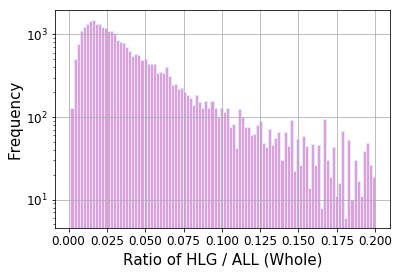

In [4]:
big = big[['IB' , 'gene' , 'R5-S#11-HLG_WHOLE_normalized_reads' , 'R5-S#11-ALL_WHOLE_normalized_reads']]
big ['Ratios: HLG / ALL (Whole)'] = big ['R5-S#11-HLG_WHOLE_normalized_reads'] / big['R5-S#11-ALL_WHOLE_normalized_reads']

# ~ 0 for not enriched
filter = big['Ratios: HLG / ALL (Whole)'] > 0
filter1 = big ['Ratios: HLG / ALL (Whole)'] <= 0.2
big.where(filter & filter1, inplace = True)

big = big.dropna()

histo = big['Ratios: HLG / ALL (Whole)'].hist(bins = 100, color = 'plum', edgecolor = 'lavender', grid = True, xlabelsize = 12, ylabelsize = 12, log = True)
plt.xlabel("Ratio of HLG / ALL (Whole)", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)

print histo

## Number of rows with a ratio between 0 and 0.2

In [6]:
big['gene'].count()

31329

## Number of unique values in the 'gene' column with a ration between 0 and 0.2

In [8]:
big['gene'].nunique()

11504

## Time to go Fishing

In [5]:
matrix = df.to_numpy()

oarfish = pd.DataFrame(matrix, columns = ["Gene", "Ratio Median",
                                          "Ratio Mean", "GO Term",
                                          "Description"])

oarfish = oarfish.drop_duplicates()

## Type of Ratio

In [6]:
data = pd.read_csv('TAG Data.csv')

data = data[['IB' , 'gene' , 'R5-S#11-HLG_WHOLE_normalized_reads' , 'R5-S#11-ALL_WHOLE_normalized_reads']]
data ['Ratios: HLG / ALL (Whole)'] = data ['R5-S#11-HLG_WHOLE_normalized_reads'] / data['R5-S#11-ALL_WHOLE_normalized_reads']

data = data.sort_values('gene')
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
data = data.drop(columns = {"R5-S#11-HLG_WHOLE_normalized_reads", 
                            "R5-S#11-ALL_WHOLE_normalized_reads"})

data["RatioType"] = np.where(data["Ratios: HLG / ALL (Whole)"] > 1, 
                                 "Hit", "Non-Hit")
data = data.sort_values("gene")
data = data.reset_index(drop = True)
data = data.replace(['unknown_chrom', 'no_gene_found', 
                     'gene_unknown'], np.nan)
data = data.dropna()

## For unknown genes

In [7]:
unknown = data[data.gene.eq("unknown_chrom") |
               data.gene.eq("no_gene_found") |
               data.gene.eq("gene_unknown")]

unknown = unknown.reset_index(drop = True)

## Iterate through entire dataframe to make dataframes for each unique gene

In [14]:
for gene, data_gene in data.groupby('gene'):
    data_gene

## Prepping to go Fishing

In [8]:
bigHit = 0
bigNo = 0

for gene, data_genie in data.groupby('gene'):
    data_genie = data_genie.drop(columns = {'IB', "Ratios: HLG / ALL (Whole)"})
   
    hit = data_genie.loc[data_genie.RatioType == 'Hit', "RatioType"].count()
    noHit = data_genie.loc[data_genie.RatioType == "Non-Hit", "RatioType"].count()

    bigHit =  bigHit + hit
    bigNo = bigNo + noHit
    if "Cre52.g761647" in data_genie.values:
        sum = pd.DataFrame (
            { 
#                 'Gene': "  ",
                'Hit' : bigHit,
                'Non-Hit' : bigNo
#                 'Total': bigTotal
            }, index = [0]
        )

#         sum = sum.to_numpy()


## Actually time to go Fishing

In [61]:
for gene, data_genie in data.groupby('gene'):
    data_genie = data_genie.drop(columns = {'IB', "Ratios: HLG / ALL (Whole)"})
   
    hit = data_genie.loc[data_genie.RatioType == 'Hit', "RatioType"].count()
    noHit = data_genie.loc[data_genie.RatioType == "Non-Hit", "RatioType"].count()
#     total = hit + noHit
    
    bigHit =  bigHit + hit
    bigNo = bigNo + noHit
#     bigTotal = bigTotal + total
    
    genius = pd.DataFrame (

        {
        'Gene':data_genie.gene.unique()
        }
    )
    
    frame = pd.DataFrame ( 
         {
#             'Gene': data_genie.gene.unique(),
            'Hit' : hit,
            'Non-Hit' : noHit
#             'Total' : total
        }, index = [0]
    )


    concat = pd.concat([frame, sum], ignore_index = True)  
    concat = concat.to_numpy()
    
    obs = np.array(concat)
    fisher = stats.fisher_exact(obs)
    
    fishy = np.asarray(fisher)
    fishy = fishy.reshape(1,2)
    
    frame.astype(float)
    sum.astype(float)
    fsh = pd.DataFrame(data = fishy, columns = ["p-value", " 1.0"])
    fsh.astype(float)
    
    oarfish = np.concatenate((frame, sum), axis = 0)
    oarfish = pd.DataFrame(data = oarfish, columns = ["Hit", "Non-Hit"])

    anchovy = pd.DataFrame(data = fsh, columns = ["p-value"])

    bigFish = pd.concat([oarfish, anchovy], ignore_index = True, sort = True)
    bigFish = pd.concat([genius, bigFish], axis = 1)
    
#     bigFish = bigFish.replace(np.nan, '-')

    #print(bigFish)

In [62]:
bigFish

,Gene,Hit,Non-Hit,p-value
0,Cre52.g761647,1.0,3.0,NaN
1,NaN,27479.0,75577.0,NaN
2,NaN,NaN,NaN,0.916785


In [11]:
append = pd.DataFrame()
for gene, data_genie in data.groupby('gene'):
    data_genie = data_genie.drop(columns = {'IB', "Ratios: HLG / ALL (Whole)"})
   
    hit = data_genie.loc[data_genie.RatioType == 'Hit', "RatioType"].count()
    noHit = data_genie.loc[data_genie.RatioType == "Non-Hit", "RatioType"].count()
#     total = hit + noHit
    
    bigHit =  bigHit + hit
    bigNo = bigNo + noHit
#     bigTotal = bigTotal + total
    
    genius = pd.DataFrame (
        {
        'Gene':data_genie.gene.unique()
        }
    )
    
    frame = pd.DataFrame ( 
         {
#             'Gene': data_genie.gene.unique(),
            'Hit' : hit,
            'Non-Hit' : noHit
#             'Total' : total
        }, index = [0]
    )

    concat = pd.concat([frame, sum], ignore_index = True)  
    concat = concat.to_numpy()
    
    obs = np.array(concat)
    fisher = stats.fisher_exact(obs)
    
    fishy = np.asarray(fisher)
    fishy = fishy.reshape(1,2)
    
    frame.astype(float)
    sum.astype(float)
    fsh = pd.DataFrame(data = fishy, columns = ["p-value", "1.0"])
    fsh.astype(float)
    
    fsh = fsh.drop(columns = {'1.0'})
    
    append = pd.concat([append, fsh], axis = 0, ignore_index = True)   

##  Array for p-values only

In [12]:
combine = append

sanc = combine.to_numpy()

In [13]:
sw = pd.DataFrame()

for gene, data_genie in data.groupby('gene'):
    ge = data_genie.gene.unique()
    ge = pd.DataFrame(data = ge, columns = ["Gene"])
    
    sw = pd.concat([sw, ge], axis = 0, ignore_index = True)

## Array for gene names only (to concatenate later)

In [20]:
ma = sw

merged = ma.join(combine)

merged.head()

,Gene,p-value
0,Cre01.g000017,0.687589
1,Cre01.g000033,0.000000
2,Cre01.g000050,1.375177
3,Cre01.g000100,0.000000
4,Cre01.g000150,0.000000


## Statsmodel

In [14]:
stanley = combine.to_numpy().flatten()

cockatoo = smm.multipletests(pvals = stanley, alpha = 0.05,
                             method = 'fdr_bh', is_sorted = False,
                             returnsorted = False)

print(cockatoo)

(array([False,  True, False, ..., False,  True, False]), array([1., 0., 1., ..., 1., 0., 1.]), 2.533374298119284e-06, 2.4695016545661086e-06)


## Try to do by lonesome

In [111]:
ordered_merged = merged.sort_values(by = 'p-value', ascending = False)

#ordered_merged = ordered_merged.dropna()

ordered_merged.reset_index(drop = False)

bye = ordered_merged

bye = bye.reset_index(drop = True)

bye.index = [x for x in range (1, len(bye.values) + 1)]

bye = bye.reset_index(drop = False)

bye["Critical B-H"] = (bye["index"] / 20247) * 0.05

bye = bye.drop(columns = {"index"})

bye['Significance'] = bye['p-value'] >= bye["Critical B-H"]

bye

,Gene,p-value,Critical B-H,Significance
0,Cre09.g387951,inf,0.000002,True
1,Cre12.g561300,inf,0.000005,True
2,Cre13.g563950 & Cre13.g564000,inf,0.000007,True
3,Cre13.g562450,inf,0.000010,True
4,Cre03.g175300 & Cre03.g175351,inf,0.000012,True
5,Cre13.g562326,inf,0.000015,True
6,Cre13.g562000,inf,0.000017,True
7,Cre13.g561800 & Cre13.g561850,inf,0.000020,True
8,Cre12.g561500 & Cre12.g561450,inf,0.000022,True
9,Cre03.g175650 & Cre03.g175700,inf,0.000025,True


In [112]:
shortened = bye.replace([np.inf, -np.inf], np.nan)

shortened = shortened.dropna()

shortened

,Gene,p-value,Critical B-H,Significance
1643,Cre17.g698365,22.002839,0.004060,True
1644,Cre03.g170550,19.252484,0.004062,True
1645,Cre09.g397550,16.502129,0.004065,True
1646,Cre16.g688450,16.502129,0.004067,True
1647,Cre12.g559300,16.502129,0.004070,True
1648,Cre12.g543302,13.751774,0.004072,True
1649,Cre16.g669000,13.751774,0.004075,True
1650,Cre06.g288550 & Cre06.g288600,13.751774,0.004077,True
1651,Cre17.g726900,13.751774,0.004080,True
1652,Cre17.g702900 & Cre17.g702950,13.751774,0.004082,True


## Find the largest p-value that is smaller than the critical value

In [113]:
greatest_least = shortened[shortened['Significance'] == False]

greatest_least

,Gene,p-value,Critical B-H,Significance
12188,Cre03.g145987,0.0,0.030101,False
12189,Cre02.g145000 & Cre02.g144950,0.0,0.030103,False
12190,Cre02.g103700 & Cre02.g103750,0.0,0.030106,False
12191,Cre02.g103770,0.0,0.030108,False
12192,Cre03.g144767,0.0,0.030111,False
12193,Cre02.g145100 & Cre02.g145050,0.0,0.030113,False
12194,Cre13.g585850 & Cre13.g585900,0.0,0.030116,False
12195,Cre16.g649700 & Cre16.g649750,0.0,0.030118,False
12196,Cre13.g585950,0.0,0.030121,False
12197,Cre13.g586000,0.0,0.030123,False


## But values that are less than the 'Critical B-H' are 0?